## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

/Users/tejaswiniallikanti/miniconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Exploring the data

In [3]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../Distributional Semantics/data/aclImdb/train')
test_ds = text_dataset_from_directory('../Distributional Semantics/data/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.
Found 25000 files belonging to 2 classes.


<ipython-input-3-7bfa2a64d8c1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xts['text'] = xts['text'].map(lambda x: x.decode())


In [4]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
72396,"For the first half of the film, as it actually attempts to make some sort of a story involving the theft of the Pink Panther, this movie almost works. However, when there are no more outtakes, or ...",2
1353,"In Manhattan, the American middle class Jim Blandings (Cary Grant) lives with his wife Muriel (Myrna Loy) and two teenage daughters in a four bedroom and one bathroom only leased apartment. Jim wo...",1
16953,Here was a director and a writer who knew that they had a real story that needed a minimum amount of added-on work to make a fine movie. The time passing early on being marked by the fighter-jets ...,2
24931,I want to state first that I am a Christian (and that I do work in the film and TV industry) so I understand what it is like to work on a feature length film so props to the filmmakers in that reg...,0
23975,The King of Masks is a beautifully told story that pits the familial gender preference towards males against human preference for love and companionship. Set in 1930s China during a time of floods...,1


In [5]:
print(dfTrain.loc[0, 'text'])

This is a great example of "film noir," as every scene has some sort of shadow pattern on the wall, the floor, the faces. All shots are done with key light on the faces. The patterns suggest "jail," "locked up," "flight" (as in a train track), "trapped," (as in a cobweb), and others. There isn't one scene that doesn't have a shadow in it! Even the day time sequences. And the actors that had great careers: Stanwyck, Gary Merrill, Claude Akins, even Jesse (the original maytag repairman) White, and, of course, George Sanders, who plays a "deNazified" ex-Nazi. Whew! Great stuff.


## Tokenize the text

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [7]:
print(train_sequences[0])

[11, 6, 3, 80, 501, 4, 19, 1460, 14, 172, 129, 44, 46, 435, 4, 2831, 6273, 20, 1, 1600, 1, 1808, 1, 1465, 29, 684, 23, 224, 15, 1296, 627, 20, 1, 1465, 1, 10593, 1478, 2618, 3008, 53, 2762, 14, 8, 3, 1233, 1441, 2387, 14, 8, 3, 29382, 2, 395, 47, 215, 27, 129, 12, 148, 25, 3, 2831, 8, 9, 56, 1, 250, 55, 814, 2, 1, 156, 12, 67, 80, 3704, 3755, 1964, 14386, 4144, 22703, 56, 3838, 1, 207, 58547, 29383, 461, 2, 4, 267, 745, 7188, 34, 284, 3, 87409, 1180, 2292, 15749, 80, 529]


In [8]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['this', 'is', 'a', 'great', 'example', 'of', 'film', 'noir', 'as', 'every', 'scene', 'has', 'some', 'sort', 'of', 'shadow', 'pattern', 'on', 'the', 'wall', 'the', 'floor', 'the', 'faces', 'all', 'shots', 'are', 'done', 'with', 'key', 'light', 'on', 'the', 'faces', 'the', 'patterns', 'suggest', 'jail', 'locked', 'up', 'flight', 'as', 'in', 'a', 'train', 'track', 'trapped', 'as', 'in', 'a', 'cobweb', 'and', 'others', 'there', "isn't", 'one', 'scene', 'that', "doesn't", 'have', 'a', 'shadow', 'in', 'it', 'even', 'the', 'day', 'time', 'sequences', 'and', 'the', 'actors', 'that', 'had', 'great', 'careers', 'stanwyck', 'gary', 'merrill', 'claude', 'akins', 'even', 'jesse', 'the', 'original', 'maytag', 'repairman', 'white', 'and', 'of', 'course', 'george', 'sanders', 'who', 'plays', 'a', 'denazified', 'ex', 'nazi', 'whew', 'great', 'stuff']


In [27]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [28]:
MAX_SEQUENCE_LENGTH

2493

In [29]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [30]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [31]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [32]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [33]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30
1172/1172 [==============================] - 24s 21ms/step - loss: -16641.9727 - accuracy: 0.1667 - val_loss: 65643.5391 - val_accuracy: 0.5000
Epoch 2/30
1172/1172 [==============================] - 27s 23ms/step - loss: -225707.7031 - accuracy: 0.1667 - val_loss: 447620.6250 - val_accuracy: 0.5000
Epoch 3/30
1172/1172 [==============================] - 37s 32ms/step - loss: -828230.2500 - accuracy: 0.1667 - val_loss: 1270633.3750 - val_accuracy: 0.5000
Epoch 4/30
1172/1172 [==============================] - 50s 43ms/step - loss: -1917466.7500 - accuracy: 0.1667 - val_loss: 2608856.2500 - val_accuracy: 0.5000
Epoch 5/30
1172/1172 [==============================] - 43s 37ms/step - loss: -3549600.5000 - accuracy: 0.1667 - val_loss: 4510364.0000 - val_accuracy: 0.5000
Epoch 6/30
1172/1172 [==============================] - 30s 26ms/step - loss: -5783278.5000 - accuracy: 0.1667 - val_loss: 7038023.0000 - val_accuracy: 0.5000
Epoch 7/30
1172/1172 [==============================]

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [15]:
glove_wiki = KeyedVectors.load_word2vec_format('data/glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

In [16]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)

Epoch 1/30
2344/2344 [==============================] - 81s 33ms/step - loss: -50649.3477 - accuracy: 0.1667 - val_loss: 184496.8906 - val_accuracy: 0.5000
Epoch 2/30
2344/2344 [==============================] - 85s 36ms/step - loss: -566044.8125 - accuracy: 0.1667 - val_loss: 1068684.7500 - val_accuracy: 0.5000
Epoch 3/30
2344/2344 [==============================] - 76s 32ms/step - loss: -1918321.1250 - accuracy: 0.1667 - val_loss: 2877956.5000 - val_accuracy: 0.5000
Epoch 4/30
2344/2344 [==============================] - 75s 32ms/step - loss: -4323605.0000 - accuracy: 0.1667 - val_loss: 5836816.5000 - val_accuracy: 0.5000
Epoch 5/30
2344/2344 [==============================] - 80s 34ms/step - loss: -8016980.5000 - accuracy: 0.1667 - val_loss: 10163823.0000 - val_accuracy: 0.5000
Epoch 6/30
2344/2344 [==============================] - 83s 35ms/step - loss: -13169944.0000 - accuracy: 0.1667 - val_loss: 16015656.0000 - val_accuracy: 0.5000
Epoch 7/30
2344/2344 [=========================

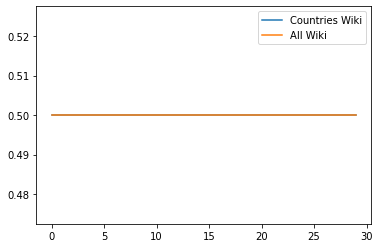

In [18]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()